# 이커머스 고객 세분화 및 구매 행동 분석

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # 모든 경고 메시지 무시

In [10]:
import matplotlib.font_manager as fm
# Windows 한글 폰트 경로
font_path = "C:/Windows/Fonts/malgun.ttf"
font = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

## 1. 데이터 로드 및 기본 확인

In [11]:
customers = pd.read_csv("./data/olist/olist_customer.csv")
orders = pd.read_csv("./data/olist/olist_orders.csv")
items= pd.read_csv("./data/olist/olist_items.csv")
products = pd.read_csv("./data/olist/olist_products.csv")

In [ ]:
# 데이터 병합 (Merge)
df = pd.merge(orders, customers, on='customer_id', how='left')
df = pd.merge(df, items, on='order_id', how='left')

df = df[df['order_status'] == 'delivered'].copy()

# 누락된 값이 있는지 확인하고 처리 (매출 분석이므로 가격 정보가 없는 행은 제거)
df = df.dropna(subset=['price'])

# 고객별 매출 집계 (Customer Unique ID 기준)
# 한 명의 고객이 여러 번 주문했을 수 있으므로 unique_id를 사용
customer_revenue = df.groupby('customer_unique_id').agg({
    'price': 'sum',
    'order_id': 'nunique'
}).reset_index()

customer_revenue.columns = ['customer_id', 'total_revenue', 'order_count']

In [13]:
# 데이터 합친 후 꼭 확인하기
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 110197 entries, 0 to 113424
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       110197 non-null  object 
 1   customer_id                    110197 non-null  object 
 2   order_status                   110197 non-null  object 
 3   order_purchase_timestamp       110197 non-null  object 
 4   order_approved_at              110182 non-null  object 
 5   order_delivered_carrier_date   110195 non-null  object 
 6   order_delivered_customer_date  110189 non-null  object 
 7   order_estimated_delivery_date  110197 non-null  object 
 8   customer_unique_id             110197 non-null  object 
 9   customer_zip_code_prefix       110197 non-null  int64  
 10  customer_city                  110197 non-null  object 
 11  customer_state                 110197 non-null  object 
 12  order_item_id                  1101

In [14]:
# 병합된 데이터의 기본 정보 확인
print("전체 데이터 행 수:", len(df))
print("-" * 30)

# 결측치(NaN) 확인: 매출 분석인데 가격(price)이 없으면 안됨
print("컬럼별 결측치 비율:")
print(df.isnull().mean() * 100)
print("-" * 30)

# 배송 완료(delivered) 데이터 비중 확인
# 취소되거나 분석에서 제외된 데이터가 얼마나 되는지 파악.
status_counts = df['order_status'].value_counts(normalize=True) * 100
print("주문 상태별 비중(%):")
print(status_counts)

# 분석 대상 데이터 확정 (배송 완료된 것만!)
df_clean = df[df['order_status'] == 'delivered'].copy()
print("-" * 30)
print(f"최종 분석 대상 데이터: {len(df_clean)}건")

전체 데이터 행 수: 110197
------------------------------
컬럼별 결측치 비율:
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.013612
order_delivered_carrier_date     0.001815
order_delivered_customer_date    0.007260
order_estimated_delivery_date    0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
price                            0.000000
freight_value                    0.000000
dtype: float64
------------------------------
주문 상태별 비중(%):
order_status
delivered    100.0
Name: proportion, dtype: float64
------------------------------
최종 분석 대상 데이터: 110197건


## 2. 파레토 분석

### 2.1 누적 매출 비중 계산

In [15]:
# 1. 고객별 총 매출액 계산 (이미 생성한 customer_revenue 활용)
# 매출 내림차순 정렬
customer_revenue = customer_revenue.sort_values(by='total_revenue', ascending=False).reset_index(drop=True)

# 2. 누적 매출액 및 누적 비율 계산
customer_revenue['cum_revenue'] = customer_revenue['total_revenue'].cumsum() # 누적 합계
total_sum = customer_revenue['total_revenue'].sum() # 전체 매출 총합
customer_revenue['cum_rev_pct'] = (customer_revenue['cum_revenue'] / total_sum) * 100 # 누적 매출 비중(%)

# 3. 고객 수 누적 비율 계산
total_customers = len(customer_revenue)
customer_revenue['cum_customer_pct'] = (customer_revenue.index + 1) / total_customers * 100

# 4. 결과 확인 (상위 10명만 보기)
print(customer_revenue.head(10))

                        customer_id  total_revenue  order_count  cum_revenue  \
0  0a0a92112bd4c708ca5fde585afaa872        13440.0            1      13440.0   
1  da122df9eeddfedc1dc1f5349a1a690c         7388.0            2      20828.0   
2  763c8b1c9c68a0229c42c9fc6f662b93         7160.0            1      27988.0   
3  dc4802a71eae9be1dd28f5d788ceb526         6735.0            1      34723.0   
4  459bef486812aa25204be022145caa62         6729.0            1      41452.0   
5  ff4159b92c40ebe40454e3e6a7c35ed6         6499.0            1      47951.0   
6  4007669dec559734d6f53e029e360987         5934.6            1      53885.6   
7  eebb5dda148d3893cdaf5b5ca3040ccb         4690.0            1      58575.6   
8  48e1ac109decbb87765a3eade6854098         4590.0            1      63165.6   
9  a229eba70ec1c2abef51f04987deb7a5         4400.0            1      67565.6   

   cum_rev_pct  cum_customer_pct  
0     0.101653          0.001071  
1     0.157531          0.002142  
2     0.211686

### 2.2 파레토 곡선 시각화

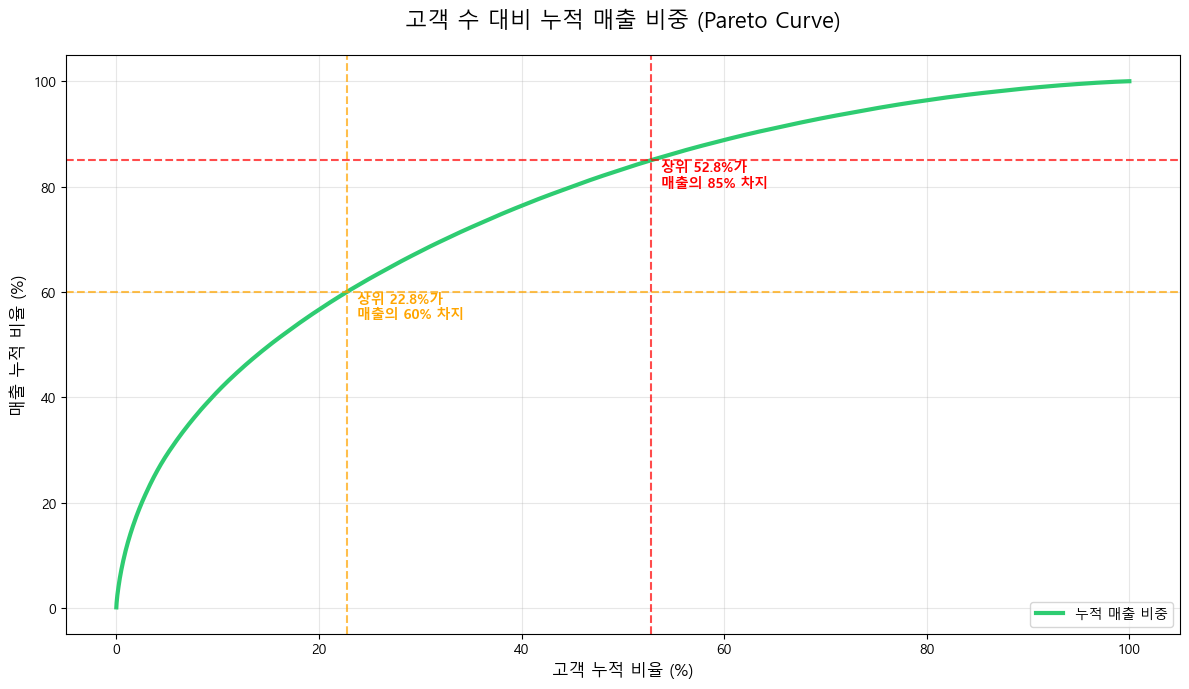

In [37]:
# 2. 그래프 크기 설정
plt.figure(figsize=(12, 7))

# 3. 누적 매출 곡선 그리기
plt.plot(customer_revenue['cum_customer_pct'], customer_revenue['cum_rev_pct'], 
         label='누적 매출 비중', color='#2ecc71', linewidth=3)

# 4. 기준선 추가 (60% 및 85% 지점)
# 매출의 60%를 차지하는 고객 비중 확인
line_60 = customer_revenue[customer_revenue['cum_rev_pct'] >= 60].iloc[0]
plt.axhline(y=60, color='orange', linestyle='--', alpha=0.7)
plt.axvline(x=line_60['cum_customer_pct'], color='orange', linestyle='--', alpha=0.7)

# 매출의 85%를 차지하는 고객 비중 확인
line_85 = customer_revenue[customer_revenue['cum_rev_pct'] >= 85].iloc[0]
plt.axhline(y=85, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=line_85['cum_customer_pct'], color='red', linestyle='--', alpha=0.7)

plt.title('고객 수 대비 누적 매출 비중 (Pareto Curve)', fontsize=16, pad=20)
plt.xlabel('고객 누적 비율 (%)', fontsize=12)
plt.ylabel('매출 누적 비율 (%)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 2.3 분석 텍스트 추가 (그래프 위에 포인트 기재)
plt.text(line_60['cum_customer_pct']+1, 55, f"상위 {line_60['cum_customer_pct']:.1f}%가\n매출의 60% 차지", color='orange', fontweight='bold')
plt.text(line_85['cum_customer_pct']+1, 80, f"상위 {line_85['cum_customer_pct']:.1f}%가\n매출의 85% 차지", color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('pareto_curve.png', dpi=300, bbox_inches='tight')

plt.show()

- 현상: 상위 **{line_60['cum_customer_pct']:1f}**의 고객이 전체 매출의 **60%**를 견인하고 있습니다.

- 진단: 신규 고객 유치도 중요하지만, 매출 기여도가 압도적인 **'헤비 유저'**층의 이탈 방지가 최우선 과제입니다.

- 제안: 85% 라인에 속하는 고객군을 대상으로 **'우수 고객 등급제'**를 강화하거나, 침구 교체 주기에 맞춘 재구매 유도 CRM 마케팅을 제안합니다.

## 3. 고객 세그먼테이션

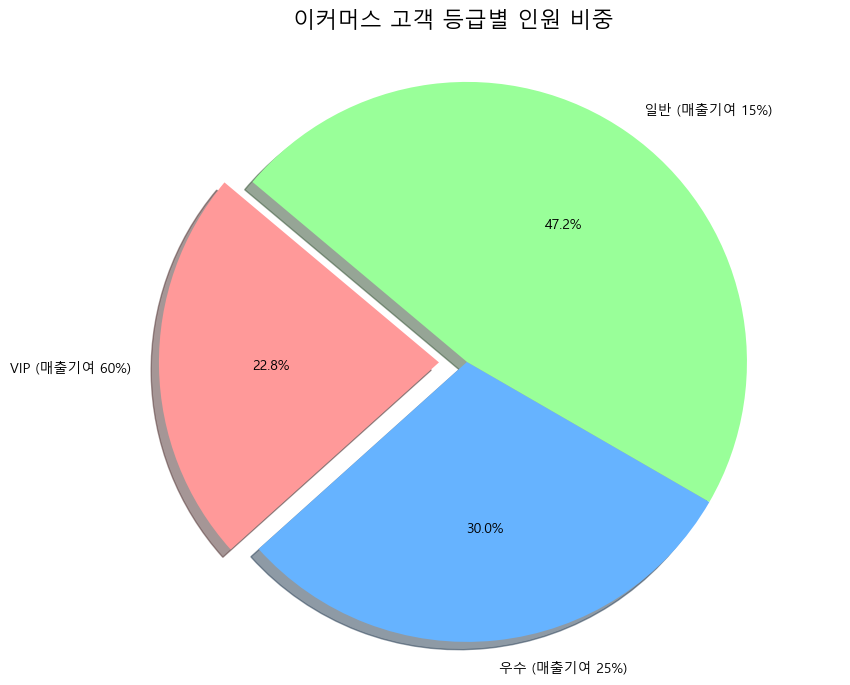

                customer_id  total_revenue
grade                                     
VIP (매출기여 60%)        21247     7932863.70
우수 (매출기여 25%)         28022     3305329.50
일반 (매출기여 15%)         44089     1983304.91


In [40]:
# 3-1. 고객 등급 정의 (매출 기여도 기준)
def categorize_customer(pct):
    if pct <= 60:
        return 'VIP (매출기여 60%)'
    elif pct <= 85:
        return '우수 (매출기여 25%)'
    else:
        return '일반 (매출기여 15%)'

customer_revenue['grade'] = customer_revenue['cum_rev_pct'].apply(categorize_customer)

grade_counts = customer_revenue['grade'].value_counts()

grade_order = ['VIP (매출기여 60%)', '우수 (매출기여 25%)', '일반 (매출기여 15%)']
grade_counts = grade_counts.reindex(grade_order)

# 3-2. 시각화 (파이 차트)
plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99'] # VIP는 눈에 띄는 색으로
explode = (0.1, 0, 0)  # VIP 조각을 약간 떼어내서 강조

plt.pie(grade_counts, labels=grade_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, explode=explode, shadow=True)

plt.title('이커머스 고객 등급별 인원 비중', fontsize=16, pad=20)
plt.axis('equal') # 원형 유지
plt.savefig('customer_segments.png', dpi=300, bbox_inches='tight')

plt.show()

# 3-3. 등급별 요약 정보 출력
summary = customer_revenue.groupby('grade').agg({
    'customer_id': 'count',
    'total_revenue': 'sum'
}).reindex(grade_order)
print(summary)

## 4. 구매 빈도 및 리텐션 분석

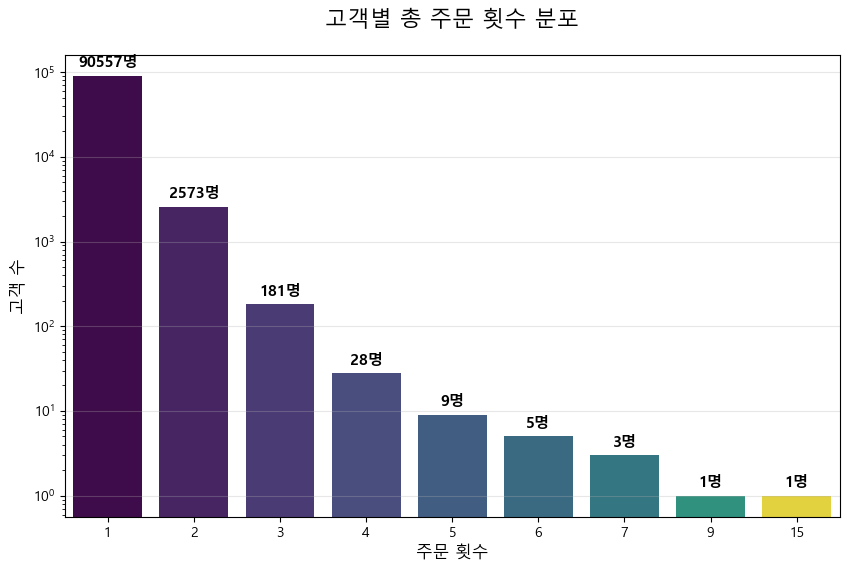

In [39]:
# 4.1 주문 횟수 분포 시각화
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x=frequency_counts.index, 
    y=frequency_counts.values, 
    hue=frequency_counts.index, 
    palette='viridis', 
    legend=False               
)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}명', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=11, fontweight='bold')

plt.title('고객별 총 주문 횟수 분포', fontsize=16, pad=20)
plt.xlabel('주문 횟수', fontsize=12)
plt.ylabel('고객 수', fontsize=12)
plt.yscale('log') 
plt.grid(axis='y', alpha=0.3)
plt.savefig('order_frequency.png', dpi=300, bbox_inches='tight')
plt.show()